In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from typing import List
import os
from utils import BASE_DATA_DIR, HORIZON_N

# HyperParameters

In [2]:
NAME = os.path.splitext(os.path.basename(__file__))[0]
metric = 'paid'

NameError: name '__file__' is not defined

In [ ]:
hyperparameters = {
    'input_size': 2,
    'hidden_size': 64,
    'num_layers': 2,
    'dropout': 0.2,
    'output_size': 2,
    'epochs': 50,
    'batch_size': 32,
    'lr': 0.001,
    'optimizer': 'Adam',
}


# LSTM FOR INDIVIDUAL CLAIM DEVELOPMENT FORECASTING
==================================================

Problem: Predict future claim payments given historical payment patterns
Structure: Each claim is ONE row, columns are payment development periods

Example Data Structure:
Claim_ID | Period_1 | Period_2 | Period_3 | Period_4 | ... | Period_N | Ultimate
---------|----------|----------|----------|----------|-----|----------|----------
   001   |   5000   |   2000   |   1500   |    500   | ... |    0     |  15000
   002   |  12000   |   8000   |   3000   |   1000   | ... |    0     |  28000
   003   |   3000   |   1000   |    500   |      ?   | ... |    ?     |    ?

Key Difference from Time Series:
- Each ROW is a claim (not a time window)
- COLUMNS are development periods (inherently sequential)
- Variable length: Claims settle at different speeds
- We want to predict remaining payments AND ultimate loss
"""

# PART 1: Import data

In [4]:
def filter_data_for_lstm_training(df_periods,evaluation_date:str='2025-09-30',clmCause:str='ABB_SLIP_&_FALL',clmStatus:List[str]=['CLOSED','PAID','DENIED']):
    """ Filter closed claims for LSTM training """
    # remove blank spaces from clmStatus and clmCause
    df_periods['clmStatus'] = df_periods['clmStatus'].str.replace(' ', '')
    df_periods['clmCause'] = df_periods['clmCause'].str.replace(' ', '')
    # filtering the data to only include claims that are closed and part of slip and fall claims
    if clmCause is not None:
        df_periods = df_periods[df_periods['clmCause'].isin([clmCause])]
    df_periods = df_periods[df_periods['clmStatus'].isin(clmStatus)]
    # remove undevelopped claims
    df_periods = df_periods[df_periods.groupby("clmNum")['period_end_date'].transform('max')<=pd.to_datetime(evaluation_date)]

    # we want at least two observations
    df_periods = df_periods[df_periods['settlement_period']>=1]
    return df_periods

In [8]:
evaluation_date = "2025-09-21"
df_periods = pd.read_parquet(
    os.path.join(BASE_DATA_DIR, evaluation_date, "closed_txn_to_periods.parquet")
)
df_periods['settlement_period'] = df_periods.groupby("clmNum")["period"].transform('max')

df_periods_non_zero = df_periods[df_periods.groupby("clmNum")[metric].transform("sum") >0]

In [9]:
df_filtered = filter_data_for_lstm_training(df_periods_non_zero,evaluation_date = evaluation_date,clmStatus=['PAID',"CLOSED","DENIED"],clmCause=None)

C:\Users\sfurderer\AppData\Local\Temp\ipykernel_27464\4242146424.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_periods['clmStatus'] = df_periods['clmStatus'].str.replace(' ', '')
C:\Users\sfurderer\AppData\Local\Temp\ipykernel_27464\4242146424.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_periods['clmCause'] = df_periods['clmCause'].str.replace(' ', '')


In [10]:
print("unique paid claims",df_periods_non_zero[df_periods_non_zero['settlement_period']>=1]['clmNum'].nunique())
print("after filter:...",df_filtered["clmNum"].nunique())

unique paid claims 3354
after filter:... 3212


In [ ]:
claims = []
for id, d in df_filtered.groupby("clmNum"):
    claims.append({'claim_id': id,
            'ultimate': d[metric].sum(),
            'payments': d[metric].to_list(),
            'reserves': d['reserve_cumsum'].to_list(),
            'settlement_period': d["period"].max()})

In [12]:
# Convert to DataFrame for easier viewing
df_claims = pd.DataFrame([
    {
        'claim_id': c['claim_id'],
        'ultimate': c['ultimate'],
        'settlement_period': c['settlement_period'],
        **{f'period_{i+1}': c['payments'][i] for i in range(len(c['payments']))}
    }
    for c in claims
])

SAMPLE CLAIM DEVELOPMENT DATA
      claim_id  ultimate  settlement_period  period_1  period_2  period_3  \
0  21000328-01   2975.50                 11       0.0       0.0       0.0   
1  21000364-01   3260.02                 10       0.0       0.0     500.0   
2  21001350-01   1175.72                 18       0.0       0.0       0.0   
3  21001364-01   3959.06                 12       0.0       0.0       0.0   
4  21001365-01   4846.47                 12       0.0      50.0       0.0   
5  21001414-01  44795.15                 56       0.0       0.0       0.0   
6  21001556-01   4248.63                 21       0.0       0.0       0.0   
7  21001598-01      7.00                 13       0.0       0.0       0.0   
8  21001736-01    690.54                 12       0.0       0.0       0.0   
9  21001865-01   2289.35                 14       0.0       0.0       0.0   

   period_4  period_5  period_6  period_7  ...  period_48  period_49  \
0       0.0      0.00      0.00       0.0  ...    

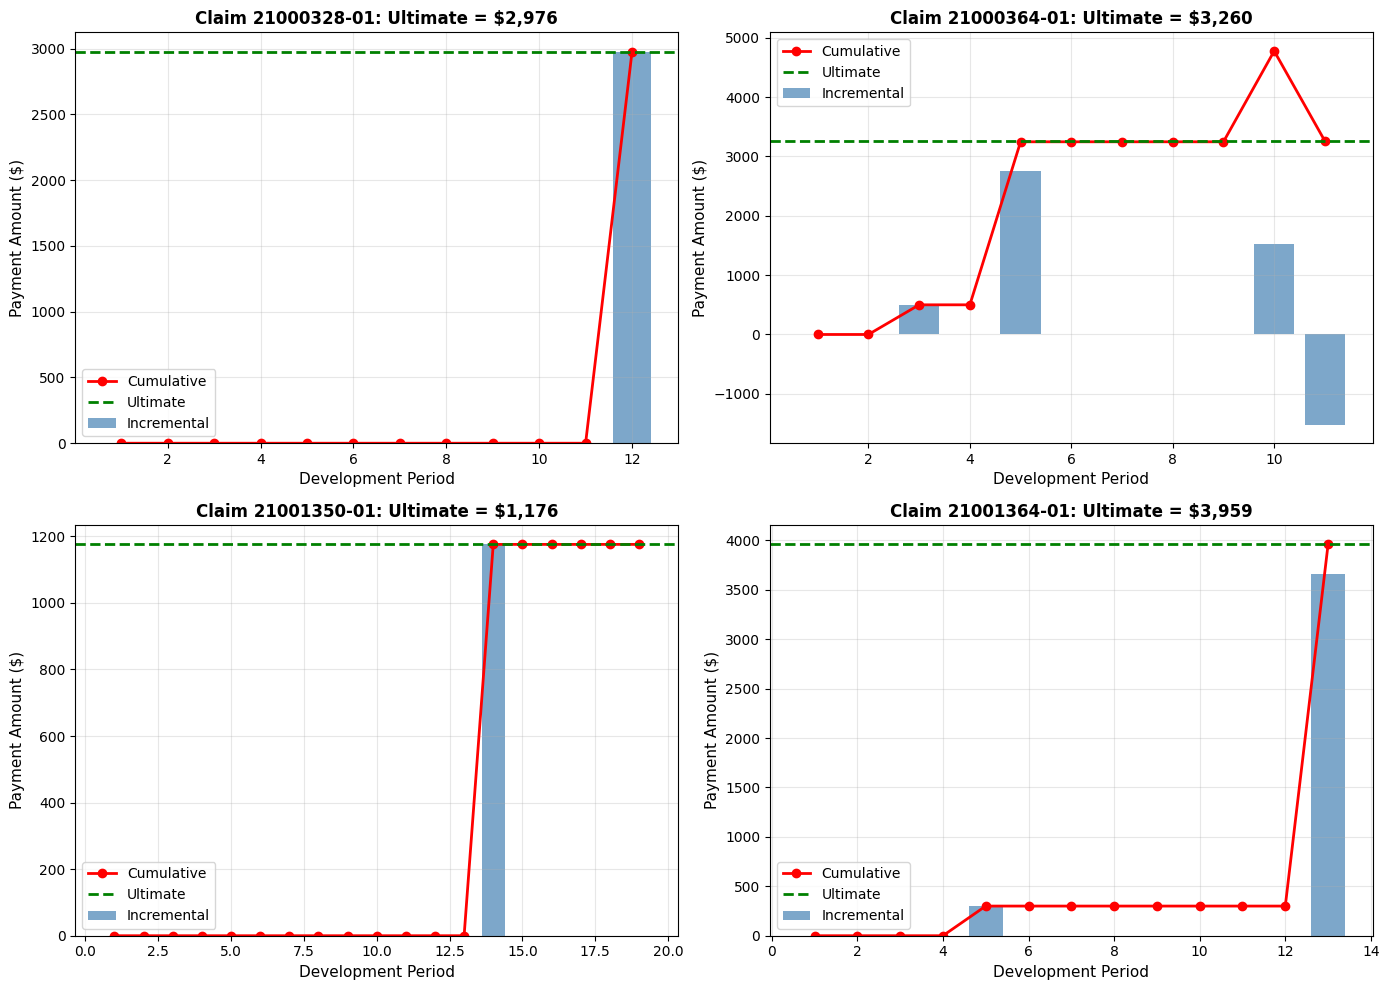

In [13]:
print("="*80)
print("SAMPLE CLAIM DEVELOPMENT DATA")
print("="*80)
print(df_claims.head(10))
print(f"\nTotal Claims: {len(df_claims)}")
print(f"Average Ultimate Loss: ${df_claims['ultimate'].mean():,.2f}")
print(f"Average Settlement Period: {df_claims['settlement_period'].mean():.1f} periods")

# Visualize sample claims
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for idx, ax in enumerate(axes.flat):
    claim = claims[idx]
    periods = range(1, len(claim['payments']) + 1)
    
    # Plot incremental payments
    ax.bar(periods, claim['payments'], alpha=0.7, color='steelblue', label='Incremental')
    
    # Plot cumulative
    cumulative = np.cumsum(claim['payments'])
    ax.plot(periods, cumulative, 'r-', linewidth=2, marker='o', label='Cumulative')
    ax.axhline(y=claim['ultimate'], color='g', linestyle='--', linewidth=2, label='Ultimate')
    
    ax.set_xlabel('Development Period', fontsize=11)
    ax.set_ylabel('Payment Amount ($)', fontsize=11)
    ax.set_title(f"Claim {claim['claim_id']}: Ultimate = ${claim['ultimate']:,.0f}", fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
#plt.savefig('sample_claim_developments.png', dpi=300, bbox_inches='tight')
plt.show()


In [14]:
# ============================================================================
# PART 2: DATA PREPARATION FOR LSTM (THE KEY DIFFERENCE)
# ============================================================================

def prepare_claim_sequences(claims_data, train_split=0.8):
    """
    Prepare data for LSTM claim forecasting
    
    KEY STRUCTURE:
    - Each claim is ONE sequence
    - We observe first N periods, predict remaining periods + ultimate
    - Training: Use various "as-of" dates (partial observations)
    """
    
    sequences = []
    
    for claim in claims_data:
        payments = np.array(claim['payments'])
        ultimate = claim['ultimate']
        
        # Create multiple training samples per claim
        # Observe first k periods, predict remainder
        # This is like evaluating the claim at different development points
        
        settlement = claim['settlement_period']
        
        for observe_until in range(2, min(settlement + 1, len(payments))):
            # Input: payments from period 1 to observe_until
            X = payments[:observe_until].copy()
            
            # Target: remaining payments + ultimate
            remaining_periods = payments[observe_until:].sum()
            
            sequences.append({
                'claim_id': claim['claim_id'],
                'observed_periods': observe_until,
                'input_sequence': X,
                'target_ultimate': ultimate,
                'target_remaining': remaining_periods,
                'paid_to_date': X.sum()
            })
    
    # Split into train/test
    np.random.shuffle(sequences)
    split_idx = int(len(sequences) * train_split)
    train_data = sequences[:split_idx]
    test_data = sequences[split_idx:]
    
    return train_data, test_data

In [15]:
train_data, test_data = prepare_claim_sequences(claims, train_split=0.8)

print("\n" + "="*80)
print("DATA PREPARATION - THE NEW STRUCTURE")
print("="*80)
print(f"Total training sequences: {len(train_data)}")
print(f"Total test sequences: {len(test_data)}")
print("\nSample Training Record:")
sample = train_data[0]
print(f"  Claim ID: {sample['claim_id']}")
print(f"  Observed until period: {sample['observed_periods']}")
print(f"  Input sequence: {sample['input_sequence']}")
print(f"  Paid to date: ${sample['paid_to_date']:,.2f}")
print(f"  Target remaining: ${sample['target_remaining']:,.2f}")
print(f"  Target ultimate: ${sample['target_ultimate']:,.2f}")

print("\n" + "="*80)
print("KEY INSIGHT: VARIABLE LENGTH SEQUENCES")
print("="*80)
print("""
Unlike time series forecasting where all samples have the same seq_length:
- Claim A observed for 3 periods: [5000, 2000, 1500]
- Claim B observed for 5 periods: [12000, 8000, 3000, 1000, 500]
- Claim C observed for 2 periods: [3000, 1000]

All are valid training examples at different stages of development!
We need to handle this with PADDING and MASKING.
""")


DATA PREPARATION - THE NEW STRUCTURE
Total training sequences: 27929
Total test sequences: 6983

Sample Training Record:
  Claim ID: 22094175-01
  Observed until period: 22
  Input sequence: [   0.     0.   175.   750.     0.   400.   200.   525.  1300.     0.
  475.   800.   947.5    0.   610.   360.  1375.     0.     0.     0.
    0.     0. ]
  Paid to date: $7,917.50
  Target remaining: $11,698.86
  Target ultimate: $19,616.36

KEY INSIGHT: VARIABLE LENGTH SEQUENCES

Unlike time series forecasting where all samples have the same seq_length:
- Claim A observed for 3 periods: [5000, 2000, 1500]
- Claim B observed for 5 periods: [12000, 8000, 3000, 1000, 500]
- Claim C observed for 2 periods: [3000, 1000]

All are valid training examples at different stages of development!
We need to handle this with PADDING and MASKING.



In [16]:
# ============================================================================
# PART 3: PYTORCH DATASET FOR VARIABLE LENGTH SEQUENCES
# ============================================================================

class ClaimDataset(torch.utils.data.Dataset):
    """Custom Dataset for variable-length claim sequences"""
    
    def __init__(self, data, scaler=None):
        self.data = data
        
        # Fit scaler on training data
        if scaler is None:
            all_payments = np.concatenate([d['input_sequence'] for d in data])
            self.scaler = StandardScaler()
            self.scaler.fit(all_payments.reshape(-1, 1))
        else:
            self.scaler = scaler
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        
        # Normalize input sequence
        X = self.scaler.transform(sample['input_sequence'].reshape(-1, 1))
        X = torch.FloatTensor(X)
        
        # Targets (we'll predict both remaining and ultimate)
        y_remaining = torch.FloatTensor([sample['target_remaining']])
        y_ultimate = torch.FloatTensor([sample['target_ultimate']])
        
        # Also return the length for padding/packing
        seq_length = torch.LongTensor([len(sample['input_sequence'])])

        # return the as of date to track the performance 
        observed_periods = torch.LongTensor([sample['observed_periods']]) 
        
        return X, y_remaining, y_ultimate, seq_length, observed_periods

def collate_fn(batch):
    """Custom collate function to handle variable lengths"""
    X_list, y_remaining_list, y_ultimate_list, lengths, obs_periods= zip(*batch)
    
    # Pad sequences to same length
    X_padded = pad_sequence(X_list, batch_first=True, padding_value=0)
    
    # Stack targets
    y_remaining = torch.stack(y_remaining_list)
    y_ultimate = torch.stack(y_ultimate_list)
    lengths = torch.stack(lengths).squeeze()
    obs_periods = torch.stack(obs_periods).squeeze()
    
    return X_padded, y_remaining, y_ultimate, lengths, obs_periods

# Create datasets
train_dataset = ClaimDataset(train_data)
test_dataset = ClaimDataset(test_data, scaler=train_dataset.scaler)

In [17]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=hyperparameters['batch_size'], 
    shuffle=True,
    collate_fn=collate_fn
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=hyperparameters['batch_size'], 
    shuffle=False,
    collate_fn=collate_fn
)

In [18]:
# ============================================================================
# PART 4: LSTM MODEL FOR CLAIM RESERVING
# ============================================================================

class ClaimReservingLSTM(nn.Module):
    """
    LSTM for predicting remaining claim payments and ultimate loss
    
    Key features:
    - Handles variable-length sequences
    - Outputs both remaining payments and ultimate loss
    - Uses packed sequences for efficiency
    """
    
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super(ClaimReservingLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Prediction heads
        self.fc_remaining = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1)
        )
        
        self.fc_ultimate = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1)
        )
    
    def forward(self, x, lengths):
        """
        x: (batch, max_seq_len, 1) - padded sequences
        lengths: (batch,) - actual lengths before padding
        """
        # Pack padded sequences for efficient processing
        packed = pack_padded_sequence(
            x, 
            lengths.cpu(), 
            batch_first=True, 
            enforce_sorted=False
        )
        
        # Process through LSTM
        packed_output, (hidden, cell) = self.lstm(packed)
        
        # Use last hidden state (from last layer)
        # Shape: (batch, hidden_size)
        last_hidden = hidden[-1]
        
        # Predict remaining and ultimate
        remaining = self.fc_remaining(last_hidden)
        ultimate = self.fc_ultimate(last_hidden)
        
        return remaining, ultimate

# Initialize model
model = ClaimReservingLSTM(input_size=hyperparameters['input_size']
                           , hidden_size=hyperparameters['hidden_size']
                           , num_layers=hyperparameters['num_layers']
                           , dropout=hyperparameters['dropout'])
print("\n" + "="*80)
print("MODEL ARCHITECTURE")
print("="*80)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")



MODEL ARCHITECTURE
ClaimReservingLSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc_remaining): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
  (fc_ultimate): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
)

Total parameters: 54,658


In [19]:
hyperparameters

{'input_size': 1,
 'hidden_size': 64,
 'num_layers': 2,
 'dropout': 0.2,
 'output_size': 2,
 'epochs': 50,
 'batch_size': 32,
 'lr': 0.001,
 'optimizer': 'Adam'}

In [20]:
# ============================================================================
# PART 5: TRAINING WITH DUAL OBJECTIVES
# ============================================================================

criterion = nn.MSELoss()

if hyperparameters['optimizer'] == "Adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters['lr'])

num_epochs = hyperparameters['epochs']
train_losses = []
test_losses = []

print("\n" + "="*80)
print("TRAINING THE MODEL")
print("="*80)

for epoch in range(num_epochs):
    # Training
    model.train()
    epoch_train_loss = 0
    
    for X_batch, y_remaining_batch, y_ultimate_batch, lengths_batch, obs_periods in train_loader:
        optimizer.zero_grad()
        
        # Forward pass
        pred_remaining, pred_ultimate = model(X_batch, lengths_batch)
        
        # Combined loss: predict both remaining and ultimate
        loss_remaining = criterion(pred_remaining, y_remaining_batch)
        loss_ultimate = criterion(pred_ultimate, y_ultimate_batch)
        loss = loss_remaining + loss_ultimate
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
    
    # Evaluation
    model.eval()
    epoch_test_loss = 0
    
    with torch.no_grad():
        for X_batch, y_remaining_batch, y_ultimate_batch, lengths_batch, obs_periods in test_loader:
            pred_remaining, pred_ultimate = model(X_batch, lengths_batch)
            loss_remaining = criterion(pred_remaining, y_remaining_batch)
            loss_ultimate = criterion(pred_ultimate, y_ultimate_batch)
            loss = loss_remaining + loss_ultimate
            epoch_test_loss += loss.item()
    
    train_losses.append(epoch_train_loss / len(train_loader))
    test_losses.append(epoch_test_loss / len(test_loader))
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_losses[-1]:.4f}")



TRAINING THE MODEL
Epoch 10/50 | Train Loss: 1197692904.3482 | Test Loss: 1283910539.6895
Epoch 20/50 | Train Loss: 1057834976.7606 | Test Loss: 1119774164.2740
Epoch 30/50 | Train Loss: 964618291.7938 | Test Loss: 1022570844.2740
Epoch 40/50 | Train Loss: 880749091.4731 | Test Loss: 912764972.8584
Epoch 50/50 | Train Loss: 805608040.7056 | Test Loss: 836751796.5297


In [21]:
# ============================================================================
# PART 6: EVALUATION AND PREDICTIONS
# ============================================================================

model.eval()
all_predictions = []

with torch.no_grad():
    for X_batch, y_remaining_batch, y_ultimate_batch, lengths_batch, obs_periods in test_loader:
        pred_remaining, pred_ultimate = model(X_batch, lengths_batch)
        
        for i in range(len(X_batch)):
            all_predictions.append({
                'observed_periods': obs_periods[i].item(),
                'actual_remaining': y_remaining_batch[i].item(),
                'pred_remaining': pred_remaining[i].item(),
                'actual_ultimate': y_ultimate_batch[i].item(),
                'pred_ultimate': pred_ultimate[i].item()
            })

df_predictions = pd.DataFrame(all_predictions)

In [22]:
# Calculate metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

results = {}
# Group by observed_periods and compute MAE/R² per group
for obs_period in sorted(df_predictions['observed_periods'].unique()):
    results[str(obs_period)] = {}
    subset = df_predictions[df_predictions['observed_periods'] == obs_period]
    mae_remaining = mean_absolute_error(subset['actual_remaining'], subset['pred_remaining'])
    mae_ult = mean_absolute_error(subset['actual_ultimate'], subset['pred_ultimate'])
    r2_ult = r2_score(subset['actual_ultimate'], subset['pred_ultimate'])
    r2_remaining = r2_score(subset['actual_remaining'], subset['pred_remaining'])
    print(f"Ult. Observed until period {obs_period}: MAE=${mae_ult:,.2f}, R²={r2_ult:.3f}, n={len(subset)}")
    print(f"Remaining Observed until period {obs_period}: MAE=${mae_remaining:,.2f}, R²={r2_remaining:.3f}, n={len(subset)}")
    results[str(obs_period)]['mae_ult'] = mae_ult
    results[str(obs_period)]['r2_ult'] = r2_ult
    results[str(obs_period)]['mae_remaining'] = mae_remaining
    results[str(obs_period)]['r2_remaining'] = r2_remaining


results_pd = pd.DataFrame(results).T
results_pd

Ult. Observed until period 2: MAE=$9,714.55, R²=-0.048, n=598
Remaining Observed until period 2: MAE=$10,049.52, R²=-0.011, n=598
Ult. Observed until period 3: MAE=$9,960.45, R²=0.152, n=577
Remaining Observed until period 3: MAE=$10,365.28, R²=0.074, n=577
Ult. Observed until period 4: MAE=$10,599.23, R²=0.123, n=521
Remaining Observed until period 4: MAE=$11,028.38, R²=0.055, n=521
Ult. Observed until period 5: MAE=$9,605.89, R²=0.167, n=488
Remaining Observed until period 5: MAE=$9,960.14, R²=0.101, n=488
Ult. Observed until period 6: MAE=$10,248.61, R²=0.025, n=444
Remaining Observed until period 6: MAE=$10,680.06, R²=0.005, n=444
Ult. Observed until period 7: MAE=$10,356.73, R²=0.157, n=436
Remaining Observed until period 7: MAE=$10,948.45, R²=0.097, n=436
Ult. Observed until period 8: MAE=$10,244.51, R²=0.424, n=395
Remaining Observed until period 8: MAE=$10,794.86, R²=0.242, n=395
Ult. Observed until period 9: MAE=$9,353.42, R²=0.579, n=372
Remaining Observed until period 9: MAE

c:\Users\sfurderer\AppData\Local\anaconda3\envs\wfm\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sfurderer\AppData\Local\anaconda3\envs\wfm\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sfurderer\AppData\Local\anaconda3\envs\wfm\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\sfurderer\AppData\Local\anaconda3\envs\wfm\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


,mae_ult,r2_ult,mae_remaining,r2_remaining
2,9714.549884,-0.047512,10049.520821,-0.011253
3,9960.449851,0.152466,10365.284208,0.074197
4,10599.225174,0.122714,11028.378772,0.054869
5,9605.894992,0.167162,9960.139456,0.100823
6,10248.613345,0.024533,10680.059874,0.004956
7,10356.727827,0.156591,10948.451688,0.097125
8,10244.505388,0.423700,10794.863349,0.242189
9,9353.416140,0.578953,10610.902452,0.260200
10,11704.647439,0.562538,12072.256181,0.250002
11,9785.869517,0.602373,10477.430562,0.298988


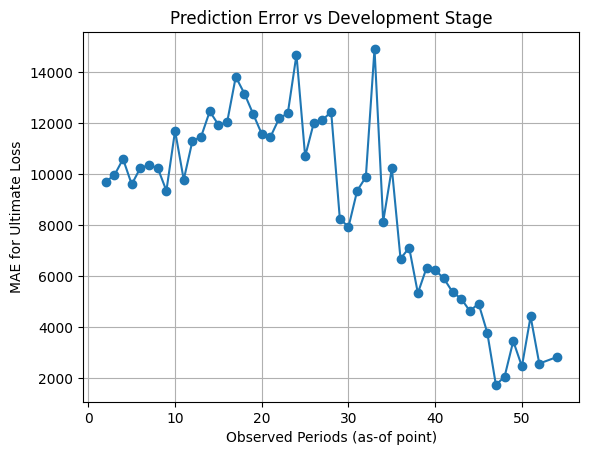

In [23]:
# Plot MAE vs observed_periods
grouped = df_predictions.groupby('observed_periods').apply(
    lambda x: mean_absolute_error(x['actual_ultimate'], x['pred_ultimate'])
)
plt.plot(grouped.index, grouped.values, marker='o')
plt.xlabel('Observed Periods (as-of point)')
plt.ylabel('MAE for Ultimate Loss')
plt.title('Prediction Error vs Development Stage')
plt.grid(True)
plt.show()

In [25]:
observed_periods = np.sort(df_predictions['observed_periods'].unique())
print(observed_periods)


[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 54]


In [33]:
selected_period = 12

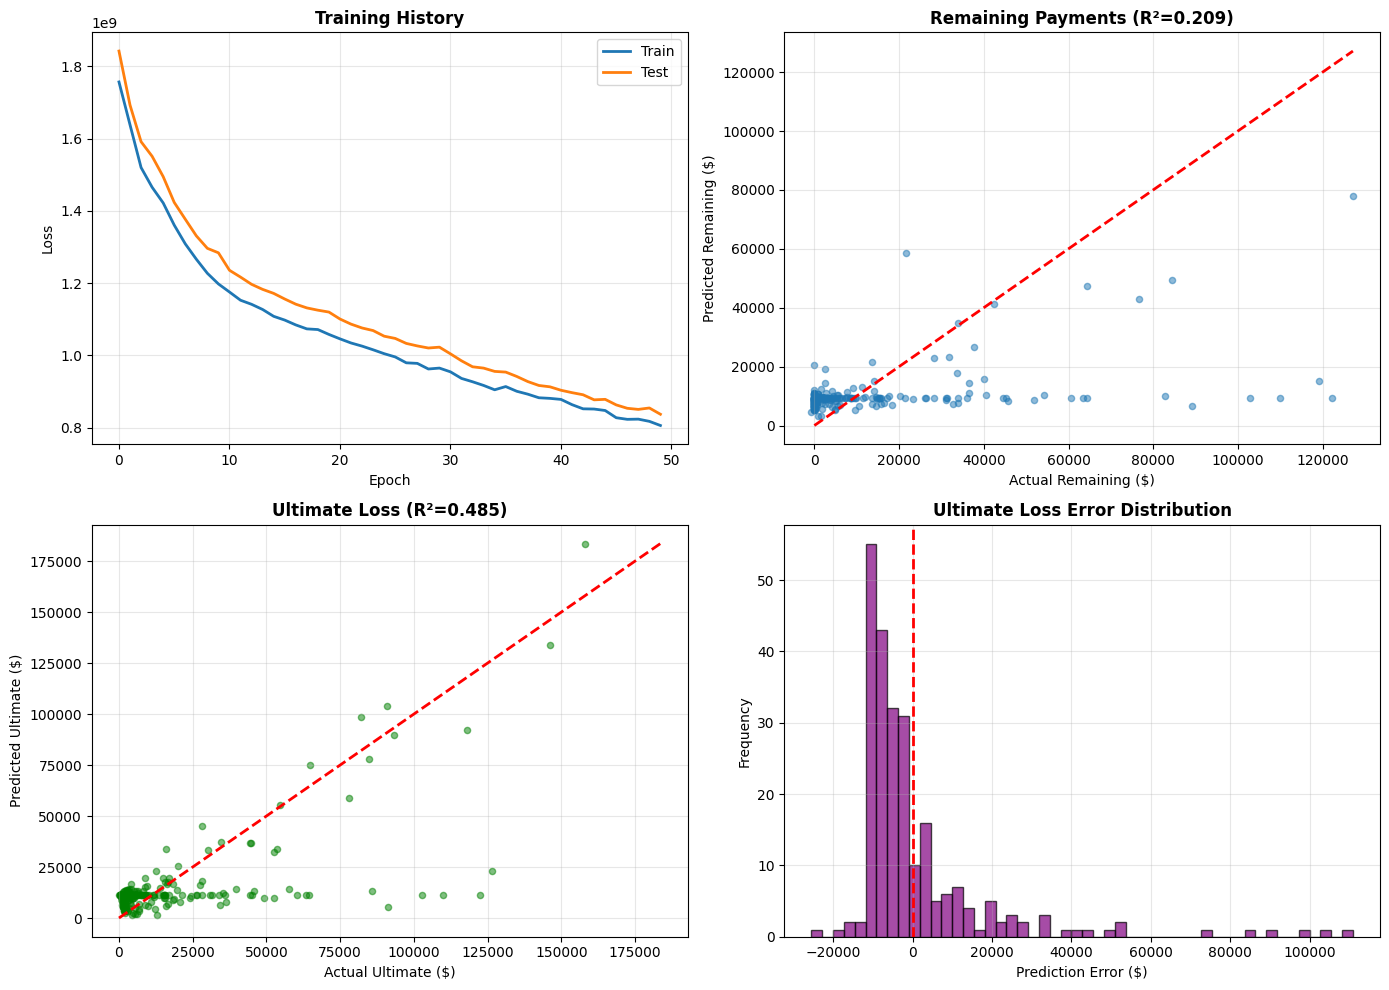

In [34]:
# ============================================================================
# PART 7: VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Training loss
axes[0, 0].plot(train_losses, label='Train', linewidth=2)
axes[0, 0].plot(test_losses, label='Test', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training History', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

df_predictions_selected = df_predictions[df_predictions['observed_periods'] == selected_period]

r2_ult = results[str(selected_period)]['r2_ult']

r2_remaining = results[str(selected_period)]['r2_remaining']
max_val = max(df_predictions_selected['actual_remaining'].max(), df_predictions_selected['pred_remaining'].max())

# Plot 2: Remaining payments prediction
axes[0, 1].scatter(df_predictions_selected['actual_remaining'], 
                   df_predictions_selected['pred_remaining'], 
                   alpha=0.5, s=20)
#max_val = max(df_predictions_selected['actual_remaining'].max(), df_predictions_selected['pred_remaining'].max())
axes[0, 1].plot([0, max_val], [0, max_val], 'r--', linewidth=2)
axes[0, 1].set_xlabel('Actual Remaining ($)')
axes[0, 1].set_ylabel('Predicted Remaining ($)')
axes[0, 1].set_title(f'Remaining Payments (R²={r2_remaining:.3f})', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Ultimate loss prediction
axes[1, 0].scatter(df_predictions_selected['actual_ultimate'], 
                   df_predictions_selected['pred_ultimate'], 
                   alpha=0.5, s=20, color='green')
max_val = max(df_predictions_selected['actual_ultimate'].max(), df_predictions_selected['pred_ultimate'].max())
axes[1, 0].plot([0, max_val], [0, max_val], 'r--', linewidth=2)
axes[1, 0].set_xlabel('Actual Ultimate ($)')
axes[1, 0].set_ylabel('Predicted Ultimate ($)')

axes[1, 0].set_title(f'Ultimate Loss (R²={r2_ult:.3f})', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Error distribution
errors_ultimate = df_predictions_selected['actual_ultimate'] - df_predictions_selected['pred_ultimate']
axes[1, 1].hist(errors_ultimate, bins=50, alpha=0.7, color='purple', edgecolor='black')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Prediction Error ($)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Ultimate Loss Error Distribution', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'claim_reserving_results_{NAME}.png', dpi=300, bbox_inches='tight')
plt.show()

In [36]:
# ============================================================================
# PART 8: PRACTICAL APPLICATION - RESERVE ESTIMATION
# ============================================================================

print("\n" + "="*80)
print("PRACTICAL APPLICATION: PORTFOLIO RESERVE ESTIMATION")
print("="*80)

# Simulate current portfolio (claims at various development stages)
#current_claims = claims[:50]  # Use first 50 claims as "current" portfolio
current_claims = [{**c}if c['settlement_period']>=3 else c for c in claims[:50]]

total_paid = 0
total_reserved_actual = 0
total_reserved_predicted = 0

model.eval()
with torch.no_grad():
    for claim in current_claims:
        # Observe claim up to a random development point
        observe_until = np.random.randint(2, max(3,min(claim['settlement_period'], 24)))
        
        # based on the information we got from the training and test, we are forcing the model to evaluate at a certain given point in time
        #observe_until = 5

        observed_payments = claim['payments'][:observe_until]
        paid_to_date = sum(observed_payments)
        actual_remaining = claim['ultimate'] - paid_to_date
        
        # Prepare input
        X = train_dataset.scaler.transform(np.array(observed_payments).reshape(-1, 1))
        X = torch.FloatTensor(X).unsqueeze(0)  # Add batch dimension
        length = torch.LongTensor([observe_until])
        
        # Predict
        pred_remaining, pred_ultimate = model(X, length)
        
        total_paid += paid_to_date
        total_reserved_actual += actual_remaining
        total_reserved_predicted += pred_remaining.item()

print(f"\nPortfolio Summary (50 claims):")
print(f"  Total Paid to Date:        ${total_paid:,.2f}")
print(f"  Actual Reserve Needed:     ${total_reserved_actual:,.2f}")
print(f"  LSTM Predicted Reserve:    ${total_reserved_predicted:,.2f}")
print(f"  Prediction Error:          ${abs(total_reserved_actual - total_reserved_predicted):,.2f}")
print(f"  Error %:                   {100 * abs(total_reserved_actual - total_reserved_predicted) / total_reserved_actual:.2f}%")

print("\n" + "="*80)
print("KEY ADVANTAGES FOR ACTUARIES")
print("="*80)
print("""
1. CLAIM-LEVEL PREDICTIONS: Unlike triangle methods, this predicts individual claims
2. VARIABLE DEVELOPMENT: Handles claims that settle at different speeds
3. DYNAMIC UPDATES: Re-predict reserves as new payments are observed
4. FEATURE RICH: Can add claim characteristics (injury type, jurisdiction, adjuster)
5. NO TRIANGLE NEEDED: Works with raw transaction data
6. PARTIAL INFORMATION: Predicts from any development stage

NEXT STEPS FOR PRODUCTION:
- Add claim features (injury severity, jurisdiction, policy type)
- Use attention mechanism for interpretability
- Implement uncertainty quantification (prediction intervals)
- Compare to chain-ladder and Bornhuetter-Ferguson methods
- Handle reopened claims and late reported claims
""")


PRACTICAL APPLICATION: PORTFOLIO RESERVE ESTIMATION

Portfolio Summary (50 claims):
  Total Paid to Date:        $58,909.55
  Actual Reserve Needed:     $420,559.38
  LSTM Predicted Reserve:    $469,732.62
  Prediction Error:          $49,173.24
  Error %:                   11.69%

KEY ADVANTAGES FOR ACTUARIES

1. CLAIM-LEVEL PREDICTIONS: Unlike triangle methods, this predicts individual claims
2. VARIABLE DEVELOPMENT: Handles claims that settle at different speeds
3. DYNAMIC UPDATES: Re-predict reserves as new payments are observed
4. FEATURE RICH: Can add claim characteristics (injury type, jurisdiction, adjuster)
5. NO TRIANGLE NEEDED: Works with raw transaction data
6. PARTIAL INFORMATION: Predicts from any development stage

NEXT STEPS FOR PRODUCTION:
- Add claim features (injury severity, jurisdiction, policy type)
- Use attention mechanism for interpretability
- Implement uncertainty quantification (prediction intervals)
- Compare to chain-ladder and Bornhuetter-Ferguson method

In [ ]:
from save_model import save_claims_model

# Save
save_path = save_claims_model(
    model=model,
    scaler=train_dataset.scaler,
    train_dataset=train_dataset,
    test_metrics=results,
    hyperparameters=hyperparameters,
    model_name=NAME
)


✅ Model saved to: models/01_ult_remaining_paid_20251001_142545
